# Assignment: Variable Auto Encoder and Latent Space Manifold visualization

In [2]:
!cp -r /kaggle/input/vaedataset/* /kaggle/working/

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Device configuration
def get_device():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("CUDA Available:", torch.cuda.is_available())
    print("CUDA Version:", torch.version.cuda)
    return device

# Set random seed for reproducibility
def set_seed(seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)
    print("Seed Set")

# Load data from .npy files (MNIST grayscale data)
def load_data(train_path, train_labels_path, val_path, val_labels_path):
    train_data = np.load(train_path)
    train_labels = np.load(train_labels_path)
    val_data = np.load(val_path)
    val_labels = np.load(val_labels_path)
    return train_data, train_labels, val_data, val_labels

# Custom Dataset class for loading data
class NumpyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data / 255.0  # Ensure the data is in the range [0, 1]
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = torch.tensor(self.data[idx], dtype=torch.float32).view(1, 28, 28)  # Add channel and reshape
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return sample, label

# Define VAE model
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=512, latent_dim=2):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encoder(self, x):
        h = torch.tanh(self.fc1(x))
        mu = self.fc21(h)
        logvar = self.fc22(h)
        return mu, logvar

    def sampling(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decoder(self, z):
        h = torch.tanh(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def decoder(self, z):
        h = torch.tanh(self.fc3(z))
        return torch.sigmoid(self.fc4(h))  # Ensures output in [0, 1] range

    def forward(self, x):
        x = x.view(-1, 784)
        mu, logvar = self.encoder(x)
        z = self.sampling(mu, logvar)
        return self.decoder(z), mu, logvar


class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dims=[512, 256, 128], latent_dim=2):
        super(VAE, self).__init__()
        
        # Encoder layers
        encoder_layers = []
        current_dim = input_dim
        for h_dim in hidden_dims:
            encoder_layers.append(nn.Linear(current_dim, h_dim))
            encoder_layers.append(nn.Tanh())
            current_dim = h_dim
        
        self.encoder_layers = nn.Sequential(*encoder_layers)
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)      # Mean layer
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)   # Log variance layer

        # Decoder layers
        decoder_layers = []
        current_dim = latent_dim
        for h_dim in reversed(hidden_dims):
            decoder_layers.append(nn.Linear(current_dim, h_dim))
            decoder_layers.append(nn.Tanh())
            current_dim = h_dim

        self.decoder_layers = nn.Sequential(*decoder_layers)
        self.fc_out = nn.Linear(hidden_dims[0], input_dim)       # Output layer

    def encoder(self, x):
        h = self.encoder_layers(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def sampling(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decoder(self, z):
        h = self.decoder_layers(z)
        return torch.sigmoid(self.fc_out(h))  # Ensures output in [0, 1] range

    def forward(self, x):
        x = x.view(-1, 784)
        mu, logvar = self.encoder(x)
        z = self.sampling(mu, logvar)
        return self.decoder(z), mu, logvar


# Define VAE loss function
def vae_loss_function(recon_x, x, mu, logvar, epoch, warmup_epochs=20, max_beta=1.0):
    beta = min(max_beta, epoch / warmup_epochs)
    x = x.view(-1, 784)
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    total_loss = recon_loss + beta * kl_divergence
    return total_loss, recon_loss, kl_divergence

# Training function
def train_vae(vae, train_loader, val_loader, optimizer, scheduler, epochs, device):
    for epoch in range(epochs):
        vae.train()
        total_loss = total_recon_loss = total_kl_divergence = 0

        for batch_idx, (batch, _) in enumerate(train_loader):
            batch = batch.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae(batch)
            loss, recon_loss, kl_divergence = vae_loss_function(recon_batch, batch, mu, logvar, epoch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_divergence += kl_divergence.item()
            #if batch_idx % 100 == 0:
            #    print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}")

        scheduler.step(total_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Total Loss: {total_loss / len(train_loader.dataset):.4f}, "
              f"Avg Recon Loss: {total_recon_loss / len(train_loader.dataset):.4f}, "
              f"Avg KL Div: {total_kl_divergence / len(train_loader.dataset):.4f}", end=" ")
        validate_vae(vae, val_loader, epoch, device)

# # Validation function
# def validate_vae(vae, val_loader, epoch, device):
#     vae.eval()
#     val_loss = val_recon_loss = val_kl_divergence = 0
#     with torch.no_grad():
#         for batch, _ in val_loader:
#             batch = batch.to(device)
#             recon_batch, mu, logvar = vae(batch)
#             loss, recon_loss, kl_divergence = vae_loss_function(recon_batch, batch, mu, logvar, epoch)
#             val_loss += loss.item()
#             val_recon_loss += recon_loss.item()
#             val_kl_divergence += kl_divergence.item()
#     print(f'Validation - Epoch [{epoch+1}], Loss: {val_loss / len(val_loader.dataset):.4f}, '
#           f'Recon Loss: {val_recon_loss / len(val_loader.dataset):.4f}, '
#           f'KL Div: {val_kl_divergence / len(val_loader.dataset):.4f}')
#     if epoch % 10 == 0:
#         show_reconstruction(vae, val_loader)
#         visualize_latent_space(vae, train_loader, device)
#     return avg_val_loss, avg_val_recon_loss, avg_val_kl_divergence

# Validation function that returns validation losses
def validate_vae(vae, val_loader, epoch, device):
    vae.eval()
    val_loss = val_recon_loss = val_kl_divergence = 0
    with torch.no_grad():
        for batch, _ in val_loader:
            batch = batch.to(device)
            recon_batch, mu, logvar = vae(batch)
            loss, recon_loss, kl_divergence = vae_loss_function(recon_batch, batch, mu, logvar, epoch)
            val_loss += loss.item()
            val_recon_loss += recon_loss.item()
            val_kl_divergence += kl_divergence.item()

    # Calculate average validation losses
    avg_val_loss = val_loss / len(val_loader.dataset)
    avg_val_recon_loss = val_recon_loss / len(val_loader.dataset)
    avg_val_kl_divergence = val_kl_divergence / len(val_loader.dataset)
    if epoch>0 and epoch %19 == 0:
        show_reconstruction(vae, val_loader)
        visualize_latent_space(vae, train_loader, device)
    print(f'Validation - Epoch [{epoch}], Loss: {avg_val_loss:.4f}, '
          f'Recon Loss: {avg_val_recon_loss:.4f}')#, KL Div: {avg_val_kl_divergence:.4f}')
    
    # Return average validation losses
    return avg_val_loss, avg_val_recon_loss, avg_val_kl_divergence


def show_reconstruction(model, val_loader, n=10):
    model.eval()
    data, _ = next(iter(val_loader))
    data = data.to(device)
    with torch.no_grad():
        recon_data, _, _ = model(data)
    
    fig, axes = plt.subplots(2, n, figsize=(15, 4))
    for i in range(n):
        # Original images
        if data[i].shape[0] == 3:  # Check if RGB
            axes[0, i].imshow(data[i].cpu().permute(1, 2, 0).numpy())
            axes[1, i].imshow(recon_data[i].cpu().view(3, 32, 32).permute(1, 2, 0).detach().numpy())
        else:  # Grayscale images
            axes[0, i].imshow(data[i].cpu().squeeze().numpy(), cmap='gray')
            axes[1, i].imshow(recon_data[i].cpu().view(28, 28).detach().numpy(), cmap='gray')
        
        axes[0, i].axis('off')
        axes[1, i].axis('off')

    plt.show()

def visualize_latent_space(vae, data_loader, device, num_batches=100):
    vae.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(data_loader):
            data = data.to(device)
            mu, logvar = vae.encoder(data.view(-1, 784))
            z = vae.sampling(mu, logvar)  # Sample z from the distribution
            latent_vectors.append(z.cpu().numpy())
            labels.extend(label.cpu().numpy())

            # Limit number of batches for visualization, if specified
            if batch_idx >= num_batches - 1:
                break

    # Concatenate all latent vectors and labels
    latent_vectors = np.concatenate(latent_vectors)
    labels = np.array(labels)

    # Plot the latent space
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter, label="Digit Label")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Latent Space Visualization")
    plt.show()
    

device = get_device()
set_seed()
train_data, train_labels, val_data, val_labels = load_data('data0.npy', 'labels0.npy', 'data.npy', 'labels.npy')

# Initialize datasets and dataloaders
train_dataset = NumpyDataset(train_data, train_labels)
val_dataset = NumpyDataset(val_data, val_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Initialize model, optimizer, and scheduler
vae = VAE(latent_dim=2).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)
#optimizer = optim.Adam(vae.parameters(), lr=1e-4)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)


# Train the model
train_vae(vae, train_loader, val_loader, optimizer, scheduler, epochs=20, device=device)
visualize_latent_space(vae, train_loader, device)




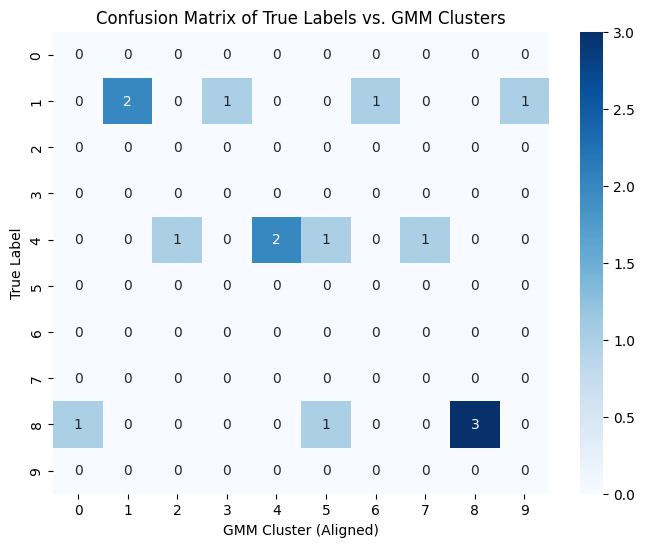

In [30]:
from sklearn.mixture import GaussianMixture
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix, accuracy_score, adjusted_rand_score
import seaborn as sns
import matplotlib.pyplot as plt

# Function to obtain latent vectors and true labels
def get_latent_vectors_and_labels(vae, data_loader, device):
    vae.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for data, label in data_loader:
            data = data.to(device)
            mu, logvar = vae.encoder(data.view(-1, 784))
            z = vae.sampling(mu, logvar)  # Sample z from the distribution
            latent_vectors.append(z.cpu().numpy())
            labels.extend(label.cpu().numpy())

    latent_vectors = np.concatenate(latent_vectors)
    labels = np.array(labels)
    return latent_vectors, labels

# Function to apply GMM and match predicted labels
def apply_gmm_and_match_labels(latent_vectors, true_labels, num_clusters=10):
    gmm = GaussianMixture(n_components=num_clusters, random_state=0)
    pred_labels = gmm.fit_predict(latent_vectors)

    # Align predicted clusters with true labels
    cm = confusion_matrix(true_labels, pred_labels)
    row_ind, col_ind = linear_sum_assignment(cm, maximize=True)
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    aligned_labels = [mapping[label] for label in pred_labels]

    return aligned_labels, cm

# Function to plot the confusion matrix
def plot_confusion_matrix(true_labels, aligned_labels):
    cm = confusion_matrix(true_labels, aligned_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("GMM Cluster (Aligned)")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix of True Labels vs. GMM Clusters")
    plt.show()


latent_vectors, true_labels = get_latent_vectors_and_labels(vae, val_loader, device)
aligned_labels, cm = apply_gmm_and_match_labels(latent_vectors, true_labels, num_clusters=10)
plot_confusion_matrix(true_labels, aligned_labels)


In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_gmm_performance(labels_true, labels_pred, zero_division=0):
    # Calculate various performance metrics
    accuracy = accuracy_score(labels_true, labels_pred)
    precision_macro = precision_score(labels_true, labels_pred, average='macro', zero_division=zero_division)
    recall_macro = recall_score(labels_true, labels_pred, average='macro', zero_division=zero_division)
    f1_macro = f1_score(labels_true, labels_pred, average='macro', zero_division=zero_division)

    # Return metrics as a dictionary
    return {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro
    }

# Example usage:
latent_vectors, true_labels = get_latent_vectors_and_labels(vae, train_loader, device)
aligned_labels, _ = apply_gmm_and_match_labels(latent_vectors, true_labels, num_clusters=10)

# Evaluate GMM performance with aligned labels
metrics = evaluate_gmm_performance(true_labels, aligned_labels, zero_division=0)
print("GMM Performance Metrics:", metrics)


GMM Performance Metrics: {'accuracy': 0.46019799294819635, 'precision_macro': 0.29362200199270316, 'recall_macro': 0.1379248012499433, 'f1_macro': 0.18752831065028777}


In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=128, latent_dim=8):
        super(VAE, self).__init__()
        
        # Encoder layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # Fully connected layer to hidden dim
        self.fc21 = nn.Linear(hidden_dim, latent_dim)  # Layer for mean (mu)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)  # Layer for log variance (logvar)
        
        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, hidden_dim)  # Fully connected layer from latent dim to hidden dim
        self.fc4 = nn.Linear(hidden_dim, input_dim)   # Output layer to reconstruct image
        
    def encoder(self, x):
        # Encode input to latent representation
        h = torch.tanh(self.fc1(x))
        mu = self.fc21(h)
        logvar = self.fc22(h)
        return mu, logvar
    
    def sampling(self, mu, logvar):
        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decoder(self, z):
        # Decode latent representation back to input space
        h = torch.tanh(self.fc3(z))
        return torch.sigmoid(self.fc4(h))
    
    def forward(self, x):
        # Flatten the input image
        x = x.view(-1, 784)
        mu, logvar = self.encoder(x)
        z = self.sampling(mu, logvar)
        return self.decoder(z), mu, logvar

    # Add a public decode method
    def decode(self, z):
        return self.decoder(z)

vae = VAE(latent_dim=2).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
#train_vae(epochs=100)
print(1)

In [27]:
from sklearn.mixture import GaussianMixture
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix, accuracy_score, adjusted_rand_score
import numpy as np

# Clustering function
def cluster_latent_space(latent_vectors, num_clusters=10):
    gmm = GaussianMixture(n_components=num_clusters, random_state=0)
    pred_labels = gmm.fit_predict(latent_vectors)
    return pred_labels

# Label matching function
def match_labels(true_labels, pred_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    row_ind, col_ind = linear_sum_assignment(cm, maximize=True)
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    mapped_labels = [mapping[label] for label in pred_labels]
    return mapped_labels

# Evaluation function
def evaluate_clustering_performance(true_labels, aligned_labels):
    acc = accuracy_score(true_labels, aligned_labels)
    ari = adjusted_rand_score(true_labels, aligned_labels)
    return {'accuracy': acc, 'adjusted_rand_index': ari}

# Usage example after obtaining latent vectors and true labels
latent_vectors = np.concatenate(latent_vectors)  # Assuming `latent_vectors` is generated from VAE
pred_labels = cluster_latent_space(latent_vectors, num_clusters=10)  # Number of clusters is based on dataset classes
aligned_labels = match_labels(labels, pred_labels)  # Assuming `labels` are true labels of the data

# Evaluate clustering performance
metrics = evaluate_clustering_performance(labels, aligned_labels)
print("Adjusted Metrics:", metrics)


Adjusted Metrics: {'accuracy': 0.4, 'adjusted_rand_index': 0.18181818181818182}


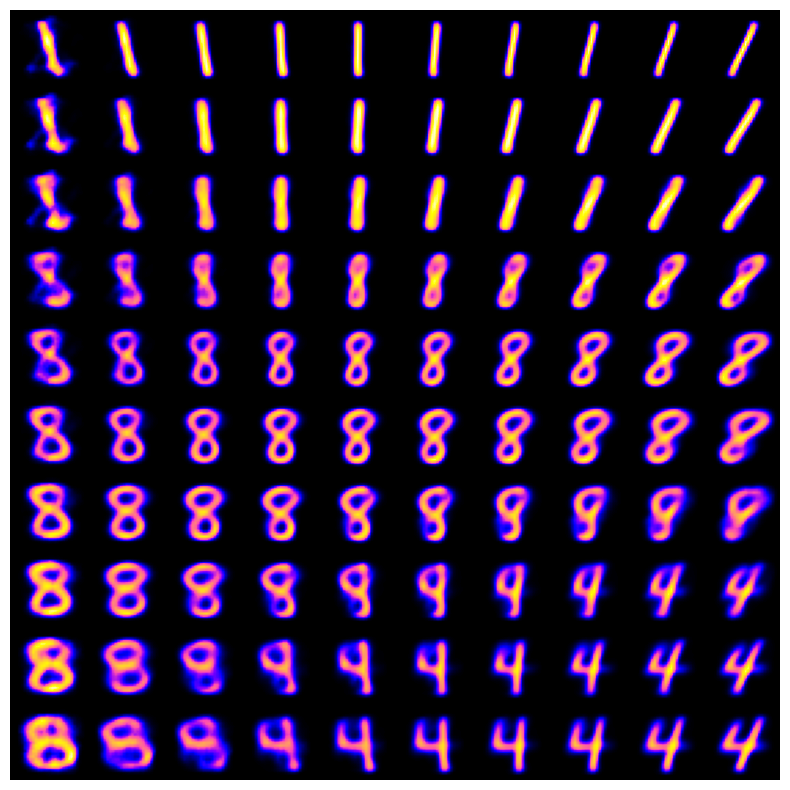

In [15]:
# Function to visualize the 2D manifold
def plot_2d_manifold(vae, latent_dim=2, n=10, digit_size=28):
    vae.eval()
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
    
    with torch.no_grad():
        for i, yi in enumerate(grid_x):
            for j, xi in enumerate(grid_y):
                z_sample = torch.zeros((1, latent_dim)).to(device)
                z_sample[0, 0] = xi
                z_sample[0, 1] = yi
                generated = vae.decoder(z_sample).cpu().numpy().squeeze()
                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = generated.reshape(digit_size, digit_size)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='gnuplot2')
    plt.axis('off')
    plt.show()

# Plot the manifold
plot_2d_manifold(vae, latent_dim=2)
